# This is a basic RNN model used to test dataset preperation and model evaluation

## Imports

In [2]:
import torch.nn as nn
import torch
import full_iri_dataset_generator as iri
from training_loop import train_model

## Constants

- `SEQUENCE_LENGTH` is the number of historical measurements before the target element to provide to the model
- `NUM_FREATURES_PER_SAMPLE` is how many details each measurement has. `IRI-only` has 3: left_iri, right_iri, and time_since_first_measurement
- `NUM_LAYERS` is the number of RNN layers to use

In [3]:
SEQUENCE_LENGTH = 10
NUM_FEATURES_PER_SAMPLE = 6
NUM_LAYERS = 5

## Dataset Preperation

Load train and test datasets

In [4]:
train, test = iri.load_iri_datasets(path="../training_data/final_data.parquet",
                                    construction_path="../training_data/construction_data.parquet",
                                    seq_length=SEQUENCE_LENGTH)

## Model Definition

Here a basic RNN classifier model is defined.

1. Data is flattened
2. RNN layers process data and modify hidden state
3. final layer maps hidden state to predicted left and right wheel IRIs
4. outputs are scaled using a logsoftmax function

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=SEQUENCE_LENGTH,
                          hidden_size=SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE,
                          num_layers=NUM_LAYERS,
                          batch_first=True)
        self.final = nn.Linear(SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE, 2)
        
    def forward(self, x):
        h0 = torch.zeros(NUM_LAYERS,
                         x.size(0),
                         SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.final(out[:, -1, :])
        return out

## Training

In [6]:
model = RNN()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_model(model, train, test, loss, optimizer, epochs=200, test_every_n=10, batch_size=512)

Training Epoch: 100%|██████████| 200/200 [02:36<00:00,  1.28it/s, Train Loss=0.00115, Test Loss=0.00154]


## R^2 Evaluation

In [17]:
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader

def compute_r2_for(dataset):
    r2 = R2Score()
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        r2.update(goal, outputs)
    return r2.compute()

model.to("cpu")
model.eval()
with torch.no_grad():
    train_r2 = compute_r2_for(train)
    print(f"R^2 for training data: {train_r2}")
    test_r2 = compute_r2_for(test)
    print(f"R^2 for testing data: {test_r2}")

R^2 for training data: 0.9438177347183228
R^2 for testing data: 0.9269988536834717


## Accuracy

In [8]:
from torcheval.metrics import MeanSquaredError

def compute_mse_for(dataset):
    mse = MeanSquaredError()
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        mse.update(outputs, goal)
    return mse.compute()

model.to("cpu")
model.eval()
with torch.no_grad():
    train_mse = compute_mse_for(train)
    print(f"MSE for training data: {train_mse}")
    test_mse = compute_mse_for(test)
    print(f"MSE for testing data: {test_mse}")

MSE for training data: 0.0011550993658602238
MSE for testing data: 0.0015605292282998562


## Error distribution

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

def compute_errors_for(dataset):
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    errors = []
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = np.array(model(inputs))
        errors.append(np.abs((outputs - np.array(goal)).mean(axis=1)))
    return np.concatenate(errors)

model.to("cpu")
model.eval()
with torch.no_grad():
    train_errors = compute_errors_for(train)
    test_errors = compute_errors_for(test)

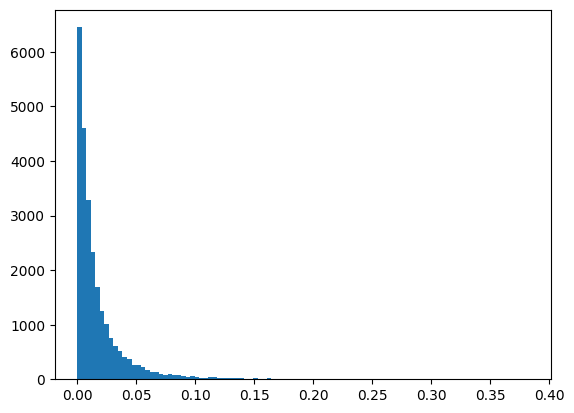

In [10]:
plt.hist(train_errors, bins=100, label="train")
plt.show()

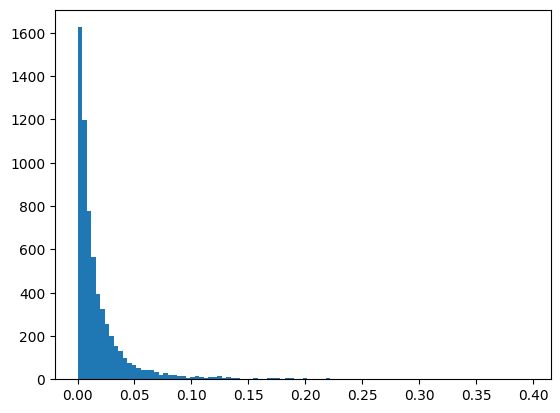

In [11]:
plt.hist(test_errors, bins=100, label="test")
plt.show()

In [12]:
print("Details of train errors:")
train_errors_df = pd.DataFrame(train_errors)
train_errors_df.describe()

Details of train errors:


,0
count,2.555400e+04
mean,1.796159e-02
std,2.590631e-02
min,5.858019e-07
25%,3.779709e-03
50%,9.494626e-03
75%,2.139443e-02
max,3.822597e-01


In [13]:
print("Details of test errors:")
test_errors_df = pd.DataFrame(test_errors)
test_errors_df.describe()

Details of test errors:


,0
count,6389.000000
mean,0.019869
std,0.031799
min,0.000010
25%,0.003895
50%,0.009661
75%,0.022625
max,0.396022


## Classification Evaluation

This was made for testing to compare this to the direct classification model to debug performance issues.

In [14]:
right = 0
wrong = 0


def increment_category_values(predicted, target):
    global right, wrong

    def get_slot(mean):
        boundries = [1.5, 2.68]
        if mean < (boundries[0] - iri.mean_iri) / iri.iri_range:
            return 0
        elif mean < (boundries[1] - iri.mean_iri) / iri.iri_range:
            return 1
        else:
            return 2
        
    if get_slot(predicted.mean()) == get_slot(target.mean()):
        right += 1
    else:
        wrong += 1

def evaluate_categorical_accuracy(dataset):
    global right, wrong
    right = 0
    wrong = 0
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        for pred, target in zip(outputs, goal):
            increment_category_values(pred, target)
    return right / (right + wrong)

device = device = torch.device("cuda")
model.eval()
with torch.no_grad():
    train_classification_accuracy = evaluate_categorical_accuracy(train)
    print(f'Classification Accuracy of the network on the train data: {100 * train_classification_accuracy}%')
    train_classification_accuracy = evaluate_categorical_accuracy(test)
    print(f'Classification Accuracy of the network on the test data: {100 * train_classification_accuracy}%')

Classification Accuracy of the network on the train data: 95.41754715504422%
Classification Accuracy of the network on the test data: 94.77226483017687%
